# Imports e carregamentos

In [1]:
import pandas as pd

# import h2o
# from h2o.automl import H2OAutoML
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [3]:
df.value_counts('result')

result
0    13181
1    13181
Name: count, dtype: int64

In [4]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'shots_home', 'shots_away', 'league',
       'corners_home', 'corners_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'fouls_home', 'fouls_away', 'tackles_home',
       'tackles_away', 'result', 'match_id', 'possessiontime_away',
       'possessiontime_home', 'f_attack_home', 'f_defensive_away',
       'f_defensive_home', 'f_attack_away', 'win_rate_home', 'loss_rate_home',
       'draw_rate_home', 'win_rate_away', 'loss_rate_away', 'draw_rate_away',
       'shotAccuracy_home', 'shotAccuracy_away', 'attackPressureOverTime_home',
       'attackPressureOverTime_away', 'aggrressionOverTime_home',
       'aggresssionOverTime_away', 'defensiveEfficacy_home',
       'taklesOverTime_home', 'taklesOverTime_away', 'possessionControl',
       'passRisk_home', 'passRisk_away', '05ht_home', '05ht_away'],
      dtype='object')

## Preprocessamento

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    return preprocessor.fit(X)
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)

# Salvando o preprocessador para uso futuro
pickle.dump(preprocessor, open('../models/preprocessor.pickle', 'wb'))

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)


Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


                                                                                 
Generation 1 - Current best internal CV score: 0.7653751051452087
                                                                                   
Generation 2 - Current best internal CV score: 0.7653751051452087
                                                                                   
Generation 3 - Current best internal CV score: 0.7653751051452087
                                                                                   
Generation 4 - Current best internal CV score: 0.7653751051452087
                                                                                   
Generation 5 - Current best internal CV score: 0.7653751051452087
                                                                                   
Generation 6 - Current best internal CV score: 0.7697377107022279
                                                                                   
Generation 7 - Cur

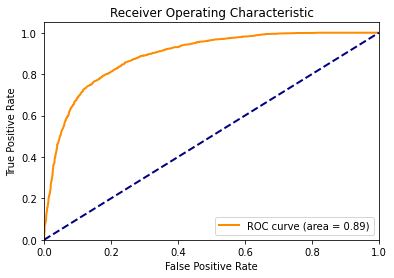

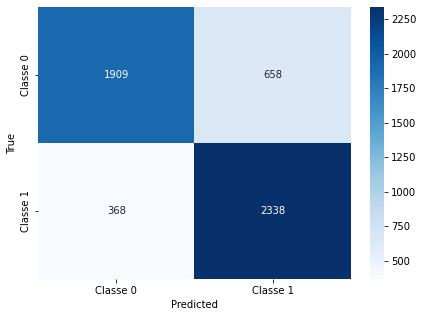

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.84      0.74      0.79      2567
    Classe 1       0.78      0.86      0.82      2706

    accuracy                           0.81      5273
   macro avg       0.81      0.80      0.80      5273
weighted avg       0.81      0.81      0.80      5273



In [8]:
from tpot import TPOTClassifier
from sklearn.metrics import classification_report

# Inicializando TPOT
tpot = TPOTClassifier(n_jobs=2, generations=10, population_size=100, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Salvando o pipeline otimizado
# tpot.export('tpot_exported_pipeline.py')

# Salvar o modelo TPOT
with open('../models/tpot_model.pkl', 'wb') as file:
    pickle.dump(tpot.fitted_pipeline_, file)

# Avaliação do Modelo
y_pred_prob = tpot.predict_proba(X_test)[:, 1]  # pegar as probabilidades da classe 1
y_pred = tpot.predict(X_test)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))
